In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255, 
    # rotation_range = 5,
    # zoom_range = (0.90, 0.90),
    # brightness_range = (0.95, 0.95),
    # horizontal_flip = True,
    # vertical_flip = True,
    data_format = 'channels_last',
    validation_split = 0.2,
    dtype = tf.bfloat16
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/AlzheimersDataset/train',
    target_size = (224, 224),
    batch_size = (32),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    seed = 123
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/AlzheimersDataset/train',
    target_size = (224, 224),
    batch_size = (32),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation',
    seed = 123
)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [ ]:
datagen2 = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 5,
    zoom_range = (0.90, 0.90),
    brightness_range = (0.95, 0.95),
    horizontal_flip = True,
    vertical_flip = True,
    data_format = 'channels_last',
    validation_split = 0.0,
    dtype = float
)

test_generator = datagen2.flow_from_directory(
    '/content/drive/MyDrive/AlzheimersDataset/test',
    target_size = (224, 224),
    batch_size = (4),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    seed = 123
)

Found 1279 images belonging to 4 classes.


In [ ]:
base_model = ResNet50V2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

94683136/94668760 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.layers

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC', 'accuracy', 'Recall', 'Precision'])

In [ ]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=100, callbacks=[es])

Epoch 1/100
129/129 [==============================] - 2255s 17s/step - loss: 3.2468 - auc: 0.8138 - accuracy: 0.6147 - recall: 0.6118 - precision: 0.6173 - val_loss: 2.1589 - val_auc: 0.7808 - val_accuracy: 0.5191 - val_recall: 0.5103 - val_precision: 0.5210
Epoch 2/100
129/129 [==============================] - 260s 2s/step - loss: 0.3284 - auc: 0.9810 - accuracy: 0.8765 - recall: 0.8694 - precision: 0.8828 - val_loss: 1.5622 - val_auc: 0.7847 - val_accuracy: 0.5474 - val_recall: 0.5318 - val_precision: 0.5568
Epoch 3/100
129/129 [==============================] - 261s 2s/step - loss: 0.1563 - auc: 0.9951 - accuracy: 0.9431 - recall: 0.9395 - precision: 0.9487 - val_loss: 1.3168 - val_auc: 0.8516 - val_accuracy: 0.5943 - val_recall: 0.5865 - val_precision: 0.5976
Epoch 4/100
129/129 [==============================] - 260s 2s/step - loss: 0.0598 - auc: 0.9994 - accuracy: 0.9863 - recall: 0.9822 - precision: 0.9882 - val_loss: 1.1188 - val_auc: 0.8714 - val_accuracy: 0.6432 - val_recal

In [ ]:
model.evaluate(validation_generator)

32/32 [==============================] - 50s 2s/step - loss: 1.0901 - auc: 0.8737 - accuracy: 0.6540 - recall: 0.6413 - precision: 0.6620


[1.0901206731796265,
 0.8737233281135559,
 0.6539589166641235,
 0.6412512063980103,
 0.6619576215744019]

In [ ]:
y_pred = model.predict(validation_generator)

In [ ]:
validation_generator.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
confusion_matrix(validation_generator.classes, np.argmax(y_pred, axis=1))

array([[ 19,   0,  61,  63],
       [  0,   0,   5,   5],
       [ 41,   1, 248, 222],
       [ 35,   2, 162, 159]])

In [ ]:
print(classification_report(validation_generator.classes, np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.20      0.13      0.16       143
           1       0.00      0.00      0.00        10
           2       0.52      0.48      0.50       512
           3       0.35      0.44      0.39       358

    accuracy                           0.42      1023
   macro avg       0.27      0.27      0.26      1023
weighted avg       0.41      0.42      0.41      1023



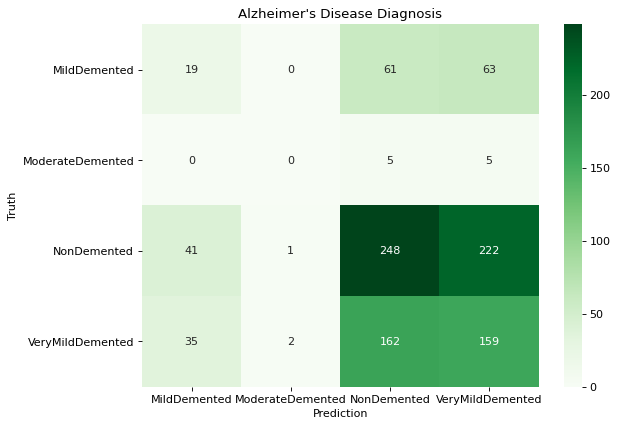

In [ ]:
CLASSES = [ 'MildDemented',
            'ModerateDemented',
            'NonDemented',
            'VeryMildDemented']

conf_arr = confusion_matrix(validation_generator.classes, np.argmax(y_pred, axis=-1))

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)